# Model Two: Solution and Comparative Statics


In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.collections import LineCollection
import matplotlib as mpl
import numpy as np
from scipy import optimize as opt
from scipy import integrate as intg
from scipy.optimize import least_squares
from scipy.stats import beta
from scipy.stats import cumfreq, beta
%matplotlib inline
plt.style.use('../notebook.mplstyle')

## Exogenous Parameters


In [2]:
# Setting exogenous parameters
def reset_exog_params():
    global Bm, Bw, bm_vals, bw_vals, δ, um, uw, Fm, Fw, λm, λw  
    Bm = 10
    Bw = 10
    bm_vals = range(1,Bm+1) 
    bw_vals = range(1,Bw+1)
    
    δ = 0.97
    um = lambda θ : θ 
    uw = lambda θ : θ
    Fm = beta(2,4)
    Fw = beta(2,4)
    λm = 30
    λw = 30

## Steady State with Cutoff Strategies

In [3]:
def steady_state(μ, ω, verbose=False): 
    # Computing z's
    zm = []
    for b in bm_vals:
        if b==Bm:
            zm.append(1-δ*Fw.cdf(μ[Bm-1]))
        else:    
            z=1
            for i in range(1, Bm-b+1): 
                z *= ((δ*(1-Fw.cdf(μ[Bm-i])))/(1-δ*Fw.cdf(μ[Bm-i-1])))   
            zm.append(z)  
        
    zw = []
    for b in bw_vals:
        if b==Bw:
            zw.append(1-δ*Fw.cdf(ω[Bw-1]))
        else:    
            z=1
            for i in range(1, Bw-b+1): 
                z *= ((δ * (1-Fm.cdf(ω[Bw-i])))/(1-δ*Fm.cdf(ω[Bw-i-1])))
            zw.append(z)    
    
    # Computing steady-state masses
    Nm = λm * ((zm[Bm-1] - δ * zm[0] * (1 - Fw.cdf(μ[0]))) / ((1-δ) * zm[Bm-1]))
    Nw = λw * ((zw[Bw-1] - δ * zw[0] * (1 - Fm.cdf(ω[0]))) / ((1-δ) * zw[Bw-1]))   
    
    # Computing steady state distribution over budgets 
    Pbm = [(λm / (Nm * zm[Bm-1])) * zm[b] for b in range(Bm-1)]
    Pbw = [(λw / (Nw * zw[Bw-1])) * zw[b] for b in range(Bw-1)]
    Pbm.append((λm / (Nm * zm[Bm-1])))
    Pbw.append((λw / (Nw * zw[Bw-1]))) 
    
    # Computing tightness and alpha
    if Nw>Nm:
        τm = 1
    else:
        τm = Nw/Nm 
        
    τw = τm *(Nm/Nw) 
    αm = (τm*δ)/(1-δ*(1-τm))
    αw = (τw*δ)/(1-δ*(1-τw))
    return Nm, Nw, Pbm, Pbw, τm, τw, αm, αw

## Two-Sided Search Equilibrium Conditions 


In [4]:
# Optimality conditions
def SME(x): 
    # Compute steady state 
    Nm, Nw, Pbm, Pbw, τm, τw, αm, αw = steady_state(x[:Bm], x[Bm:])
    
    Um = um
    Uw = uw
    # Computing ex-ante expected utilities 
    
    # Initialysing system of equilibrium equations
    E = np.empty(2*Bm + 2*Bw + 2)
    
    # Initial conditions 
    E[0] = (Um(x[0]) 
            - αm * Um(x[0]) * Fw.cdf(x[0]) 
            - αm * intg.quad(lambda t: Um(t) * Fw.pdf(t), x[0], 1)[0]) 
    
    E[Bm] = (Uw(x[Bm]) 
            - αw * Uw(x[Bm]) * Fm.cdf(x[Bm]) 
            - αw * intg.quad(lambda t: Uw(t) * Fm.pdf(t), x[Bm], 1)[0]) 
    
    # Intertemporal optimality conditions for men
    for b in range(1,Bm):
        E[b] = (Um(x[b]) 
                - αm * Um(x[b]) * Fw.cdf(x[b]) 
                - αm * Um(x[b-1])*(1-Fw.cdf(x[b-1])) 
                - αm * intg.quad(lambda t : Um(t) * Fw.pdf(t), x[b], x[b-1])[0])
    
    # Intertemporal optimality conditions for women
    for b in range(1,Bw):
        E[Bm+b] = (Uw(x[Bm+b]) 
                - αw * Uw(x[Bm+b]) * Fm.cdf(x[Bm+b]) 
                - αw * Uw(x[Bm+b-1])*(1-Fm.cdf(x[Bm+b-1])) 
                - αw * intg.quad(lambda t : Uw(t) * Fm.pdf(t), x[Bm+b], x[Bm+b-1])[0])
        
    # PMF unity sum conditions
    E[Bm+Bw] = sum(Pbm)-1
    E[Bm+Bw+1] = sum(Pbw)-1
    
    # PMF non-negativity conditions
    for b in range(Bm):
        E[Bm+Bw+2+b] = Pbm[b]-abs(Pbm[b])
        
    for b in range(Bw): 
        E[Bm+Bw+2+Bm+b] = Pbw[b]-abs(Pbw[b])    
        
    return E 

## Solving For Steady State Equilibria 

In [5]:
reset_exog_params()
m_test = np.random.rand(Bm)#*0.5
w_test = np.random.rand(Bw)#*0.5  

print('μ0: ', m_test)
print('ω0: ', w_test)
print('')

x_start = np.concatenate((m_test, w_test), axis=None)
solution = least_squares(SME, x_start, bounds = (0,1), verbose=1) 

μ_star = solution.x[:Bm]
ω_star = solution.x[Bm:]
print('')
print('μ*', μ_star) 
print('ω*', ω_star) 
print('Loss:', round(solution.cost,6))

μ0:  [0.34893036 0.9296505  0.71391544 0.41888783 0.43224701 0.85786085
 0.74877984 0.77951117 0.66257288 0.93447439]
ω0:  [0.32838977 0.6225691  0.32539105 0.48639648 0.91122567 0.03346747
 0.88081562 0.29192896 0.09118616 0.478956  ]

`gtol` termination condition is satisfied.
Function evaluations 8, initial cost 1.5215e-01, final cost 2.0842e-20, first-order optimality 1.06e-11.

μ* [0.526524   0.45591668 0.41087663 0.37729289 0.35035712 0.32781029
 0.30839844 0.29134882 0.27614945 0.26244259]
ω* [0.526524   0.45591668 0.41087663 0.37729289 0.35035712 0.32781029
 0.30839844 0.29134882 0.27614945 0.26244259]
Loss: 0.0


In [6]:
# Computing steady state
Nm, Nw, Pbm, Pbw, τm, τw, αm, αw = steady_state(μ_star, ω_star, True)
print('Masses: ', round(Nm), round(Nw))
print('PMF check:', round(sum(Pbm),3), round(sum(Pbw),3))
print('Tightness: ', round(τm,2), round(τw,2))
print('Alphas: ', round(αm,2), round(αw,2)) 

ρm = sum([(1 - Fm.cdf(ω_star[b]))*Pbw[b] for b in range(Bw)])
ρw = sum([(1 - Fw.cdf(μ_star[b]))*Pbm[b] for b in range(Bm)])
print('Average Pr(right-swipe): ', round(ρm, 2), round(ρw, 2))

Masses:  559 559
PMF check: 1.0 1.0
Tightness:  1 1.0
Alphas:  0.97 0.97
Average Pr(right-swipe):  0.4 0.4


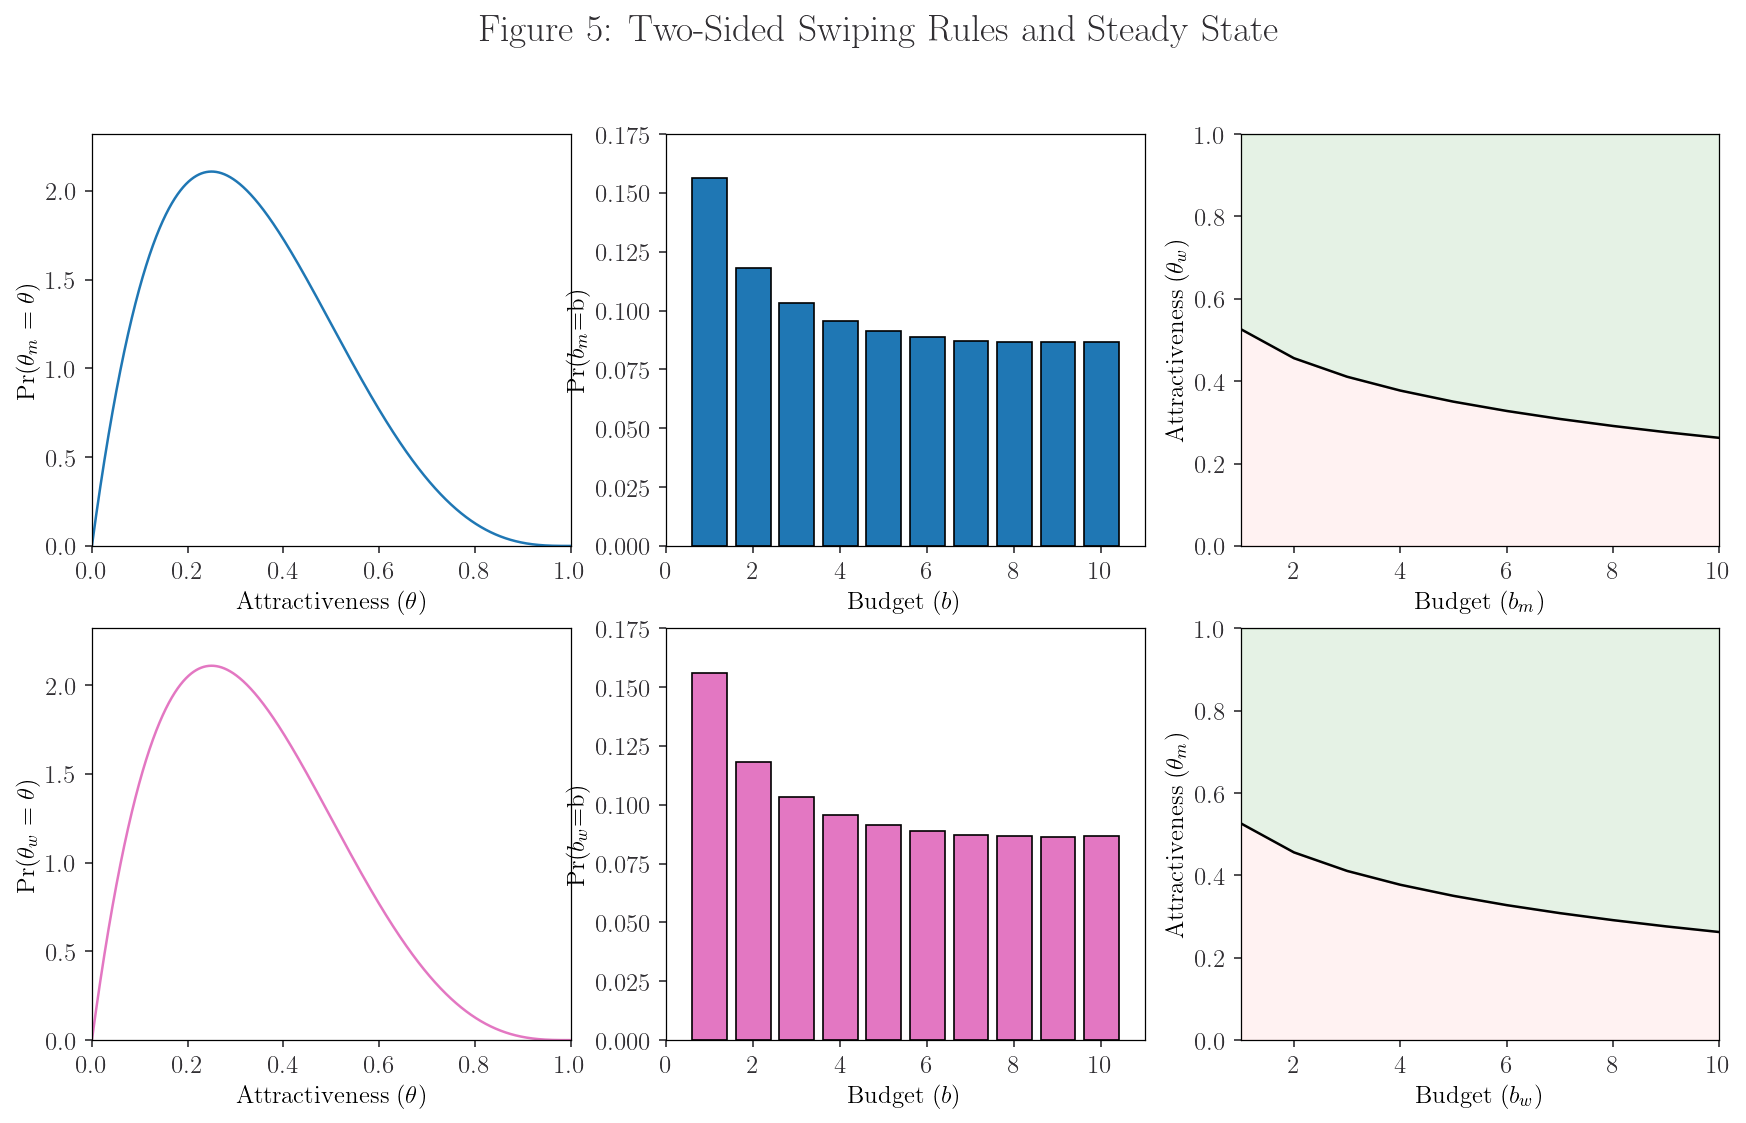

In [7]:
# Plotting Marginal PDFs
fig, axs = plt.subplots(2,3,figsize=(14, 8))
x = np.linspace(0, 1, 5000)

axs[0,0].set_xlim(0,1)
axs[0,0].set_ylim(0,1.1*max(Fm.pdf(x)))
axs[0,0].plot(x, Fm.pdf(x), color='tab:blue') 

axs[1,0].set_xlim(0,1)
axs[1,0].set_ylim(0,1.1*max(Fw.pdf(x)))
axs[1,0].plot(x, Fw.pdf(x), color='tab:pink')

# Plotting Marginal PMFs 
axs[0,1].set_xlim(0,Bm+1)
axs[0,1].bar(bm_vals, Pbm, color='tab:blue') 

axs[1,1].set_xlim(0,Bw+1)
axs[1,1].bar(bw_vals, Pbw, color='tab:pink') 

axs[0,1].set(xlabel=r'Budget ($b$)', ylabel=r'Pr($b_m$=b)') 
axs[1,1].set(xlabel=r'Budget ($b$)', ylabel=r'Pr($b_w$=b)') 

#axs[0,0].set_title('Men',loc='center')
axs[0,0].set(xlabel=r'Attractiveness ($\theta$)', ylabel=r'Pr($\theta_m=\theta$)')

#axs[0,1].set_title('Women',loc='center')
axs[1,0].set(xlabel=r'Attractiveness ($\theta$)', ylabel=r'Pr($\theta_w=\theta$)')


for i in range(2):
    B = Bm if i==0 else Bw
    b_vals = bm_vals if i==0 else bw_vals
    θ_vals = μ_star if i==0 else ω_star
    
    axs[i,2].set_xlim(1,B)
    axs[i,2].set_ylim(0,1)
    axs[i,2].plot(b_vals, θ_vals, color='k')
    axs[i,2].fill_between(b_vals, 0, θ_vals, color='red', alpha=0.05)
    axs[i,2].fill_between(b_vals, θ_vals, 1, color='green', alpha=0.1)
axs[0,2].set(xlabel=r'Budget ($b_m$)', ylabel=r'Attractiveness ($\theta_w$)')
axs[1,2].set(xlabel=r'Budget ($b_w$)', ylabel=r'Attractiveness ($\theta_m$)')
fig.suptitle('Figure 5: Two-Sided Swiping Rules and Steady State ')
plt.savefig('../../figures/mkt-cs.png')
plt.show()